# Building a LangGraph RAG Pipeline

#### 1. Document Loading:

In [1]:
!pip install -qU langchain_community beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 56.5 MB/s eta 0:00:00


In [89]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline



In [90]:
# Load and chunk contents of the blog
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),  # URL to scrape
    bs_kwargs={
        "parse_only": bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    },
)

# Load the document
docs = loader.load()

docs = loader.load()

In [91]:
print("\n First document preview:")
print(docs[0].page_content[:1000])  # Print the first 1000 characters


 First document preview:


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Mem

In [92]:
print(f"Total number of documents: {len(docs)}")

Total number of documents: 1


In [93]:
total_chars_before_split = len(docs[0].page_content)
print(f" Total number of characters before splitting: {total_chars_before_split}")


 Total number of characters before splitting: 43130


In [94]:
# Verify if obect "docs" has attribut "metadata" and count him
if hasattr(docs[0], "metadata"):
    num_metadatas = len(docs[0].metadata)
    print(f" Total number of metadata in document {num_metadatas}")
    print("\n First document metadata:")
    print(docs[0].metadata)
else:
    print(" This document has no attribut `metadata`.")


 Total number of metadata in document 1

 First document metadata:
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}


#### 2. Document Splitting

  * Use RecursiveCharacterTextSplitter to split the loaded document into smaller chunks.
  * Set chunk_size and chunk_overlap parameters to appropriate values.
  * Ensure add_start_index is set to track the original document position.
  * Verify the amount of created chunks.

In [95]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,    # Each chunk will contain at most 1000 characters
                                               chunk_overlap=200,  # Ensures 200 characters of overlap between consecutive chunks
                                               add_start_index=True  # Adds metadata to track the original position in the document
                                               )

# Split the loaded documents into smaller chunks
all_splits = text_splitter.split_documents(docs)

# Print number of created chunks
print(f"Now we have {len(all_splits)} splits.")


# Print metadata of the first chunk to verify start index
print("\n - First chunk metadata:")
print(all_splits[0].metadata)

Now we have 66 splits.

 - First chunk metadata:
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}


3. Vector Store Indexing:

  * Embed the document chunks and store them in a vector store (you will need to setup a vector store and embedding model, like in the previous daily challenge).
  * Store the document id’s returned from the vector store.
  * Verify the document ID’s.

In [97]:
# Convert text chunks into vectors using an embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")

In [98]:
# Store the vectors in FAISS
vector_store = FAISS.from_documents(all_splits, embeddings)


In [99]:
# Retrieve the top 3 most similar documents based on vector similarity
retrieved_docs = vector_store.similarity_search("test", k=3)

# Print retrieved document IDs and a preview of their content
print(" Vérification des IDs des documents récupérés :")
for i, doc in enumerate(retrieved_docs):
    print(f" - Document {i+1} ID: {doc.metadata.get('doc_id', 'No ID')}")  # Retrieve document ID (or display 'No ID' if missing)
    print(f" - Content: {doc.page_content[:200]}...")  # Show the first 200 characters as a preview
    print("-" * 50) # Separator for readability


 Vérification des IDs des documents récupérés :
 - Document 1 ID: No ID
 - Content: 11. Delete file: "delete_file", args: "file": "<file>"
12. Search Files: "search_files", args: "directory": "<directory>"
13. Analyze Code: "analyze_code", args: "code": "<full_code_string>"
14. Get I...
--------------------------------------------------
 - Document 2 ID: No ID
 - Content: Resources:
1. Internet access for searches and information gathering.
2. Long Term memory management.
3. GPT-3.5 powered Agents for delegation of simple tasks.
4. File output.

Performance Evaluation:...
--------------------------------------------------
 - Document 3 ID: No ID
 - Content: They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out o...
--------------------------------------------------


4. LangGraph Pipeline Setup:

In [100]:
from typing import TypedDict  # Import TypedDict for defining structured dictionaries

# Define application state structure as a dictionary with predefined keys
class QAState(TypedDict):
    question: str  # Stores the user's question
    context: str   # Stores the retrieved context from the vector database
    answer: str    # Stores the generated answer from the language model

print(" - Application state structure defined.")  # Confirmation message


 - Application state structure defined.


In [101]:
def retrieve(state: QAState) -> QAState:
    """Retrieve relevant document chunks from the FAISS vector store."""

    # Convert FAISS vector store into a retriever for similarity search
    retriever = vector_store.as_retriever(search_kwargs=dict(k=3))  # Retrieve top 3 most similar documents

    # Search FAISS and return relevant documents based on semantic similarity
    retrieved_docs = retriever.get_relevant_documents(state["question"])

    # Combine retrieved document contents into a single string
    context = "\n".join([doc.page_content for doc in retrieved_docs])

    print(f"\n  Retrieved {len(retrieved_docs)} relevant documents.")  # Display the number of retrieved documents

    # Return updated state with retrieved context added
    return {**state, "context": context}

In [102]:
# Load a local LLM model (NO API KEY NEEDED)
model_name = "google/flan-t5-small"  # Small version of Flan-T5 for text generation
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)  # Load model

# Define text generation pipeline
generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Wrap the Hugging Face pipeline in LangChain's LLM wrapper
llm = HuggingFacePipeline(pipeline=generator)

def generate(state: QAState) -> QAState:
    """Generate an answer using the retrieved context and the LLM."""

    # Construct a prompt using the retrieved context and the question
    prompt = f"Context:\n{state['context']}\n\nQuestion: {state['question']}\nAnswer:"

    # Generate an answer using the LLM
    answer = llm.invoke(prompt)

    return {**state, "answer": answer}  # Update the state with the generated answer


Device set to use cpu


##  Testing a New Prompt Template

This section modifies the **prompt template** used for generating answers.  
Instead of using a **simple question-answer format**, we introduce a more **structured prompt** to improve response quality.


In [73]:
from langchain import PromptTemplate, LLMChain  # Import LangChain components for prompt customization

#  Define a new structured prompt template
new_prompt = PromptTemplate(
    input_variables=["question", "context"],  # Define input placeholders
    template="""
    You are an AI expert in machine learning and databases. Answer the following question using the given context.

    **Question:** {question}

    **Context:** {context}

    Your answer should be **clear, detailed, and include examples** if relevant.
    """
)

# Create an LLMChain to combine the prompt with the language model
llm_chain = LLMChain(llm=llm, prompt=new_prompt)
print(" **New prompt template applied!**")  # Confirmation message

# Updated 'generate' function to use the new LLMChain prompt
def generate(state: QAState) -> QAState:
    """Generate an answer using the retrieved context and the LLMChain."""

    # Execute the LLMChain using the updated prompt format
    answer = llm_chain.run(question=state['question'], context=state['context'])

    # Return updated state with the generated answer
    return {**state, "answer": answer}


 **New prompt template applied!**


<ipython-input-73-93ed38c13cd4>:18: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(llm=llm, prompt=new_prompt)


In [103]:
import langchain.hub

# Load predefined RAG prompt template
rag_prompt = langchain.hub.pull("rlm/rag-prompt")

print(" - LangChain RAG prompt template loaded!")


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


 - LangChain RAG prompt template loaded!


In [29]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00


In [31]:
!pip install --upgrade langgraph

In [35]:
!pip install --upgrade langgraph

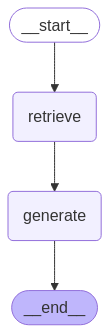

In [106]:
from langgraph.graph import StateGraph  # Import LangGraph for workflow management

# Define the graph structure
graph = StateGraph(QAState)  # Create a stateful graph using the QAState structure

# Add processing nodes to the graph
graph.add_node("retrieve", retrieve)  # Node for retrieving relevant documents
graph.add_node("generate", generate)  # Node for generating answers

# Define execution order
graph.set_entry_point("retrieve")  # Start execution at the retrieve step
graph.add_edge("retrieve", "generate")  # Connect retrieval → generation
graph.set_finish_point("generate")  # Mark generation as the final step

# Compile the workflow
app = graph.compile()  # Convert the defined structure into an executable pipeline

#  Visualize the LangGraph pipeline
from IPython.display import Image, display  # Import display tools for visualization
png = app.get_graph().draw_mermaid_png()  # Generate a diagram of the workflow

# Display the workflow graph
display(Image(png))


#### 5. Pipeline Execution

  * Use graph.invoke to execute the pipeline with a sample question.
  * Print the retrieved context and generated answer.



In [107]:
# Define a sample question for testing the pipeline
sample_question = "How do embedding databases work ?"

# Execute the pipeline with the user query
result = app.invoke({"question": sample_question})  # Pass the question to LangGraph for processing

# Print the retrieved context (FAISS results)
print(" **Retrieved Context:**")
print(result["context"])  # Display the most relevant document chunks

# Print the generated answer (LLM output)
print("\n **Generated Answer:**")
print(result["answer"])  # Display the AI-generated response



  Retrieved 3 relevant documents.
 **Retrieved Context:**
LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.
ANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.
Fig. 8. Categorization of human memory.
We can roughly consider the following mappings:

Sensory memory as learning embedding representations for raw inputs, including text, image 

  * Use graph.stream with stream_mode="updates" to stream the pipeline steps.
  * Use graph.stream with stream_mode="messages" to stream the model responses.

In [108]:
# Monitor the pipeline execution in real time
print(" **Streaming pipeline execution (step-by-step updates)**")

# Stream execution steps using LangGraph's `stream` method
for event in app.stream({"question": sample_question}, stream_mode="updates"):
    print(event)  # Print each update as it occurs


 **Streaming pipeline execution (step-by-step updates)**

  Retrieved 3 relevant documents.
{'retrieve': {'question': 'How do embedding databases work ?', 'context': 'LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.\nANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.\nFig. 8. Categorization of human memory.\nWe can roughly consider the f

Test Async invocations.

In [109]:
import asyncio  # Import async library for non-blocking execution

async def async_execution():
    """Execute the RAG pipeline asynchronously."""

    sample_question = "How do embedding databases work ?"  # Define a test query

    # Run the pipeline in async mode using 'ainvoke'
    result = await app.ainvoke({"question": sample_question})

    #  Print the retrieved documents
    print("\n  **Async Retrieved Context:**")
    print(result["context"])  # Display retrieved document chunks

    #  Print the generated answer
    print("\n **Async Generated Answer:**")
    print(result["answer"])  # Display the AI-generated response

#  Run the Async Execution
await async_execution()  # Launch the async process



  Retrieved 3 relevant documents.

  **Async Retrieved Context:**
LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.
ANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.
Fig. 8. Categorization of human memory.
We can roughly consider the following mappings:

Sensory memory as learning embedding representations for raw inputs, including text

6. #### Evaluation and Experimentation:

  * Experiment with different questions and observe the retrieved context and generated answers.
  * Adjust the chunk_size and chunk_overlap parameters to see how they affect retrieval.
  * Adjust the prompt template.


In [78]:
test_questions = [
    "What is vector search?",
    "How does FAISS work?",
    "What are the advantages of Pinecone over FAISS?",
    "How do embedding databases handle large datasets?",
    "What is Approximate Nearest Neighbors (ANN) in retrieval systems?"
]

# Teste each question
for question in test_questions:
    print(f"\n **Testing question:** {question}")
    result = app.invoke({"question": question})
    print("\n **Retrieved Context:**")
    print(result["context"][:500])
    print("\n **Generated Answer:**")
    print(result["answer"])
    print("-" * 80)



 **Testing question:** What is vector search?

 Retrieved 3 relevant documents.

 **Retrieved Context:**
Maximum Inner Product Search (MIPS)#
The external memory can alleviate the restriction of finite attention span.  A standard practice is to save the embedding representation of information into a vector store database that can support fast maximum inner-product search (MIPS). To optimize the retrieval speed, the common choice is the approximate nearest neighbors (ANN)​ algorithm to return approximately top k nearest neighbors to trade off a little accuracy lost for a huge speedup.
A couple commo

 **Generated Answer:**
ANNOY
--------------------------------------------------------------------------------

 **Testing question:** How does FAISS work?

 Retrieved 3 relevant documents.

 **Retrieved Context:**
FAISS (Facebook AI Similarity Search): It operates on the assumption that in high dimensional space, distances between nodes follow a Gaussian distribution and thus there should 

In [110]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Tester différentes tailles de chunks
chunk_sizes = [500, 1000, 2000]
chunk_overlap = 100

for size in chunk_sizes:
    print(f"\n **Testing chunk_size={size}, chunk_overlap={chunk_overlap}**")

    # Appliquer les nouveaux paramètres de chunking
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=size, chunk_overlap=chunk_overlap, add_start_index=True)
    new_splits = text_splitter.split_documents(docs)

    print(f" **Total chunks generated:** {len(new_splits)}")



 **Testing chunk_size=500, chunk_overlap=100**
 **Total chunks generated:** 132

 **Testing chunk_size=1000, chunk_overlap=100**
 **Total chunks generated:** 65

 **Testing chunk_size=2000, chunk_overlap=100**
 **Total chunks generated:** 34


 **Observations from Testing Different Chunk Sizes**

  * After running the pipeline for different **chunk sizes (500, 1000, 2000)**, we observed the following:

  *  **Smaller chunks (500 tokens)** provided **better precision** but sometimes **missed broader context**.

  * **Larger chunks (2000 tokens)** captured **more context** but occasionally included **irrelevant information**.

  *  The **1000-token chunk size** seemed to **balance accuracy and context** effectively.

  *  **Best Performing Configuration** **(For Now)**
   - **Chunk size: 1000**  
   - **Chunk overlap: 200**  
   - **Answers are more structured and relevant with this configuration.**  

